In [1]:
import os
import cv2 as cv
import numpy as np
from pathlib import Path
from easyocr import Reader
from ultralytics import YOLO
from matplotlib import pyplot as plt

from card_reader.logger import logger
from card_reader.utils.common import read_yaml

6.0


In [2]:
%pwd

'/Users/apple/Documents/Personal/Computer Vision and Deep Learning/card-reader-ml/research'

In [3]:
os.chdir('../')

In [4]:
def imshow(image, title):
  plt.imshow(image, cmap='gray')
  plt.title(title)
  plt.axis('off')
  plt.show()

In [5]:
class LayoutPredictionPipeline:
  def __init__(self) -> None:
    self.model = YOLO('model/best.pt')
    self.classes = read_yaml(Path('model/data.yaml')).names
    self.reader = Reader(['en'], detector="DB", gpu=False)

  def layout_extraction(self, image, box):
      x1, y1, x2, y2 = box.xyxy[0]
      x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
      return image[y1:y2, x1:x2]
  
  def text_extraction(self, output):
    text = []
    for item in output:
      text.append(item[1])
    return text
  
  def get_class(self, id):
    return self.classes[int(id)]
  
  def is_excluded(self, class_name):
    exclude = ['mykad', 'mykid', 'mykad_icon', 'mykid_icon', 'flag', 'heading']
    return class_name in exclude

  
  def get_card(self, image):
    image = np.array(image)
    result = self.model.predict(image)
    for res in result:
      boxes = res.boxes
      for box in boxes:
        if self.get_class(box.cls) == 'mykad':
          self.card = self.layout_extraction(image, box)
          break
  
  def predict(self):
    try:
      response = {}
      result = self.model(self.card)
      for res in result:
        boxes = res.boxes
        logger.info('Cropping IC from image')
        for box in boxes:
          class_name = self.get_class(box.cls)
          if not self.is_excluded(class_name):
            layout = self.layout_extraction(self.card, box)
            output = self.reader.readtext(layout)
            text = self.text_extraction(output=output)
            if class_name not in response.keys():
              response[class_name] = text
              imshow(layout, class_name)
      logger.info('Text Extracted')
      return response
    except Exception as e:
      logger.error(e)
      raise e
    
  def get_layouts(self):
    try:
      kernel = np.ones((5,5),np.float32)
      response = {}
      result = self.model(self.card)
      for res in result:
        boxes = res.boxes
        for box in boxes:
          class_name = self.get_class(box.cls)
          if not self.is_excluded(class_name):
            layout = self.layout_extraction(self.card, box)
            print(layout.shape, class_name, box.conf)
            if layout.shape[1] != 0:
              imshow(layout, f"{class_name} {box.conf}")
      #       output = self.reader.readtext(layout)
      #       text = self.text_extraction(output=output)
      #       response[class_name] = text
      # return response
    except Exception as e:
      logger.error(e)
      raise e


In [6]:
ic = cv.imread('data/20.jpg')
ic = cv.cvtColor(ic, cv.COLOR_BGR2RGB)
# ret, thresh = cv.threshold(ic, 125, 255, cv.THRESH_BINARY_INV)
# imshow(thresh, 'thresh')

[2024-04-16 20:51:50,764 : WARNING : easyocr : Using CPU. Note: This module is much faster with a GPU.]



0: 416x640 1 flag, 1 gender, 1 heading, 1 ic_number, 1 mykad, 1 mykad_icon, 1 name, 2 religions, 128.2ms
Speed: 3.5ms preprocess, 128.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 flag, 1 gender, 1 heading, 1 ic_number, 1 level, 1 mykad, 1 name, 2 religions, 115.9ms
Speed: 2.6ms preprocess, 115.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


[2024-04-16 20:51:54,385 : INFO : 2169026612 : Cropping IC from image]


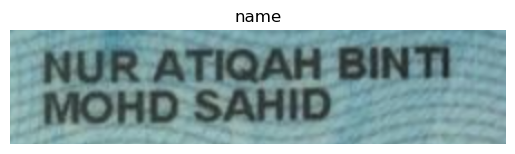

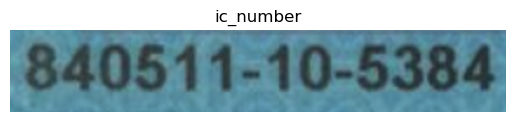

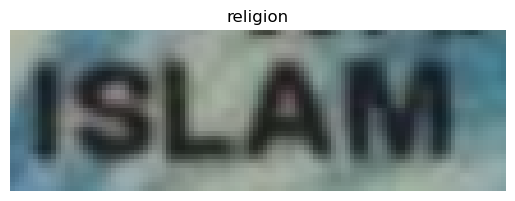

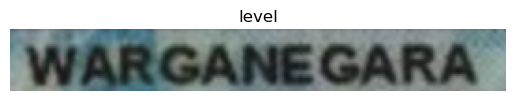

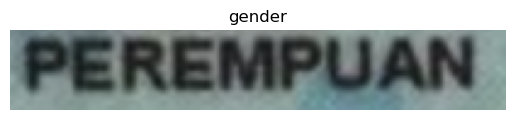

[2024-04-16 20:51:56,593 : INFO : 2169026612 : Text Extracted]


{'name': ['NUR ATIQAH BINTI', 'MOHD SAHID'],
 'ic_number': ['840511-10-5384'],
 'religion': ['ISLAM'],
 'level': ['WARGANEGARA'],
 'gender': ['PEREMPUAN']}

In [8]:
# cropping
predictor = LayoutPredictionPipeline()
predictor.get_card(ic)
result = predictor.predict()
# imshow(predictor.card, 'cropped')
# imshow(ic, 'original')
result